In [4]:
import pandas as pd
from tabulate import tabulate
import re

# Define the URL and column names
upi_url = "https://storage.googleapis.com/gsearch_share/gsearch_jobs.csv"
columns = ['title', 'company_name', 'location', 'salary_avg','salary_min','salary_max', 'date_time']

# Load the CSV data into a dataframe
df = pd.read_csv(upi_url, usecols=columns)

def clean_title(title):
    words = re.findall(r'\b\w+\b', title)[:3]  # Keep only the first three words without weird characters
    cleaned_title = ' '.join(words)
    return cleaned_title

# Apply the clean_title function to the title column
df['title'] = df['title'].apply(clean_title)

# Define a regular expression pattern to match the desired character
pattern = r'^(.*?),'

# Apply the regular expression pattern to clean the location column
df['location'] = df['location'].apply(lambda x: re.match(pattern, str(x)).group(1) if pd.notnull(x) and isinstance(x, str) and re.match(pattern, str(x)) else x)

# Clean the date_time column and extract the year
df['date_time'] = pd.to_datetime(df['date_time']).dt.year

# Sort the DataFrame by company name and date_time
df_sorted = df.sort_values(['company_name', 'date_time'])

# Group the DataFrame by company name
groups = df_sorted.groupby('company_name')

# Fill NaN values in salary_avg column with values from other job listings of the same company
df['salary_avg'] = groups['salary_avg'].apply(lambda x: x.ffill().bfill())
df['salary_min'] = groups['salary_min'].apply(lambda x: x.ffill().bfill())
df['salary_max'] = groups['salary_max'].apply(lambda x: x.ffill().bfill())

# Delete rows with NaN values in the salary_avg column
df = df.dropna(subset=['salary_avg'])
df = df.dropna(subset=['salary_min'])
df = df.dropna(subset=['salary_max'])
# Reset the index after removing rows
df = df.reset_index(drop=True)

# Define a function to replace job titles
def replace_job_titles(title):
    if title == "Sr Data Analyst" or title == "Senior Data Analytics":
        return "Senior Data Analyst"
    elif title == "Data analyst BI" or title == "Business Data Analyst":
        return "Business Intelligence Analyst"
    elif title == "Senior Performance Marketing":
        return "Marketing Data Analyst"
    elif title in ["Data analyst", "Data Analyst II", "Data Analyst III", "Data Analyst I","Data Analyst for"]:
        return "Data Analyst"
    else:
        return title

# Apply the replace_job_titles function to the title column
df['title'] = df['title'].apply(replace_job_titles)

# Display a limited number of rows using the tabulate library
table = tabulate(df.head(10), headers='keys', tablefmt='fancy_grid')
print(table)


<ipython-input-4-6f7b87be96af>:36: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df['salary_avg'] = groups['salary_avg'].apply(lambda x: x.ffill().bfill())
<ipython-input-4-6f7b87be96af>:37: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df['salary_min'] = groups['salary_min'].apply(lambda x: x.f

╒════╤══════════════════════════╤════════════════════════════╤═══════════════╤═════════════╤══════════════╤══════════════╤══════════════╕
│    │ title                    │ company_name               │ location      │   date_time │   salary_avg │   salary_min │   salary_max │
╞════╪══════════════════════════╪════════════════════════════╪═══════════════╪═════════════╪══════════════╪══════════════╪══════════════╡
│  0 │ Data Analyst             │ Robert Half                │ Oklahoma City │        2023 │       56.375 │        52.25 │         60.5 │
├────┼──────────────────────────┼────────────────────────────┼───────────────┼─────────────┼──────────────┼──────────────┼──────────────┤
│  1 │ Experienced Data Analyst │ Upwork                     │ Anywhere      │        2023 │       56     │        37    │         75   │
├────┼──────────────────────────┼────────────────────────────┼───────────────┼─────────────┼──────────────┼──────────────┼──────────────┤
│  2 │ Data Analyst             │ 

<ipython-input-4-6f7b87be96af>:38: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df['salary_max'] = groups['salary_max'].apply(lambda x: x.ffill().bfill())


In [ ]:
# Count the occurrences of each title
title_counts = df['title'].value_counts()

# Print the first 10 titles with their counts
print(title_counts.head(10))


Data Analyst                     1054
Senior Data Analyst              1016
Lead Data Analyst                 300
Business Intelligence Analyst     222
Marketing Data Analyst            101
Data Scientist                     68
Principal Data Analyst             50
Data Analyst Immigration           38
Healthcare Data Analyst            38
Research Data Analyst              34
Name: title, dtype: int64


In [2]:
!pip install catboost


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.0 MB/s eta 0:00:00


In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define the features (X) and the target variable (y)
X = df[['title', 'company_name', 'location', 'date_time','salary_min','salary_max']]
y = df['salary_avg']

# Perform one-hot encoding to convert categorical variables into numerical representation
X_encoded = pd.get_dummies(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Train the CatBoost model
model = CatBoostRegressor(iterations=1000, depth=6, learning_rate=0.1, loss_function='RMSE', random_state=42)
model.fit(X_train, y_train, verbose=False)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared:", r2)



Mean Absolute Error: 1038.0960616918237
Mean Squared Error: 41302535.47826033
R-squared: 0.9858430918948107


With an MAE of 1038.09 and an MSE of 41302535.47, it suggests that, on average, the predicted salaries deviate by approximately $1038.09 from the actual salaries. The R-squared value of 0.98 indicates that the model explains around 98.5% of the variance in the target variable, which is a good fit for the data.

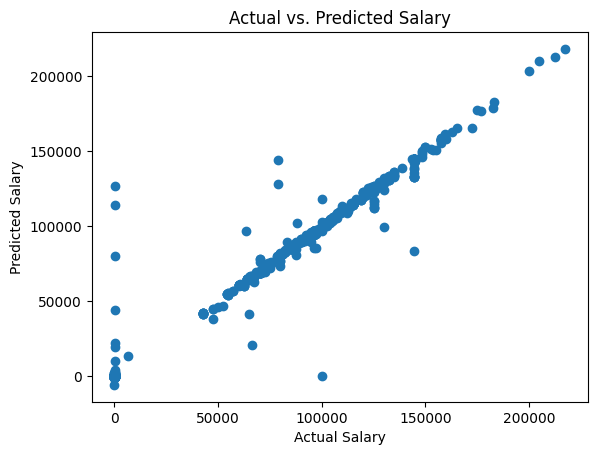

In [13]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.title('Actual vs. Predicted Salary')
plt.show()




compare the predicted salaries with the actual salaries. This will help you visualize how well the model's predictions align with the ground truth values.

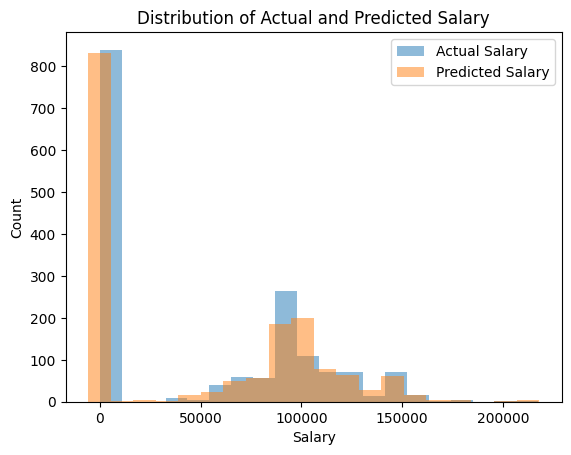

In [14]:
plt.hist(y_test, bins=20, alpha=0.5, label='Actual Salary')
plt.hist(y_pred, bins=20, alpha=0.5, label='Predicted Salary')
plt.xlabel('Salary')
plt.ylabel('Count')
plt.title('Distribution of Actual and Predicted Salary')
plt.legend()
plt.show()



Plot the distribution of the predicted salaries and the actual salaries to compare their distributions and identify any discrepancies.

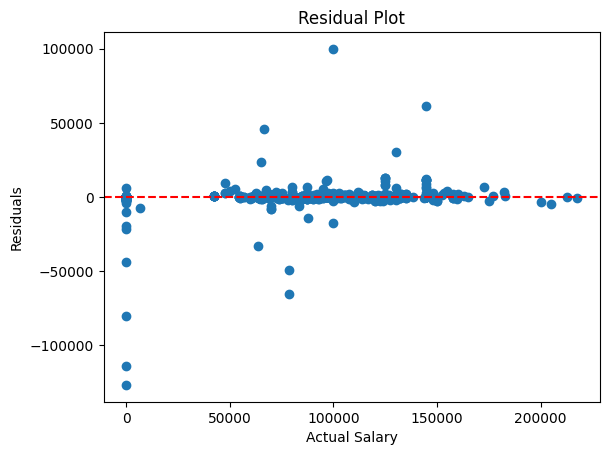

In [15]:
residuals = y_test - y_pred
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Salary')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


Plot the residuals (the differences between the predicted and actual salaries) to analyze the model's performance across the range of salaries. It helps you identify any patterns or biases in the predictions.